### Prereqs:
1. uv pip install playwright # pip install pytest-playwright
2. playwright install
3. playwright install-deps chromium
4. pip install html5lib
5. pip install lxml==5.2.1

Jupyter notebook doesn't run. It nested async loops through Jupyter only works on certain OSs.

Current System Details:  
Ubuntu 24.04.2 LTS (GNU/Linux 5.15.167.4-microsoft-standard-WSL2 x86_64)
System information as of Thu Jul 24 04:14:56 UTC 2025

Python: 3.12.3

Library:  
nest-asyncio==1.6.0  
gradio==5.28.0  
gradio_client==1.10.0  

In [1]:
import os
os.chdir('./../')

In [2]:
import dotenv
import textwrap
from typing import Annotated
from typing_extensions import TypedDict

import gradio as gr
import nest_asyncio
import requests
from IPython.display import Image, display
from langgraph import graph
from langgraph import prebuilt
from langchain.agents import Tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_google_genai import ChatGoogleGenerativeAI

dotenv.load_dotenv(override=True)

from common.constants import Constants
from common.tools.pushover import Pushover

/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class State(TypedDict):    
    messages: Annotated[list, graph.message.add_messages]

In [4]:
graph_builder = graph.StateGraph(State)

In [5]:
nest_asyncio.apply()

In [6]:
async_browser =  create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()
tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>),
 GetElementsTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/som

In [7]:
tool_dict = {tool.name:tool for tool in tools}
navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

In [8]:
await navigate_tool.arun({"url": "https://someshchatterjee.com"})
text = await extract_text_tool.arun({})

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order 2b2dd596-093a-4a2d-854f-62777ed829fa has timestamp 2025-08-03 07:28:09.08307 +0000 UTC earlier than parent timestamp 2025-08-03 07:28:09.887898 +0000 UTC for run_id:2b2dd596-093a-4a2d-854f-62777ed829fa trace_id:a01dceaf-2959-4c1d-9258-425b4db57281 dotted_order:20250803T072809884606Za01dceaf-2959-4c1d-9258-425b4db57281.20250803T072809887898Z388bc671-2902-4fb8-a034-ada00016a23d.20250803T072809083070Z2b2dd596-093a-4a2d-854f-62777ed829fa parent_run_id:388bc671-2902-4fb8-a034-ada00016a23d"}\n')


In [9]:
print(textwrap.fill(text))

Somesh Chatterjee Somesh Chatterjee Developer @ Heart Pages Home About
Saturday, May 11, 2019 Problems of the 'new' keyword How do we create
an object in most languages? It's by using the 'new' keyword and
there's a big problem lurking in there! Some languages of-course skip
it, like Python, where you can create an instance of class just by
doing 'ClassName()' instead of 'new ClassName()' but the underlying
problem remains the same. The new keyword causes our codes to get
coupled. Let's take this simple example: interface IShape {   public
string Name { get; } } class Square : IShape {   public string Name {
get; private set; }   public Square()   {     Name = "Square";   } }
class Circle : IShape {   public string Name { get; private set; }
public Circle()   {     Name = "Circle";   } } class ShapeHolder {
public IShape Shape { get; private set; }   ShapeHolder()   {
shape = new Square();   } } If we see the above example, even though
we have used an interface 'IShape', our ShapeHolde

In [10]:
tool_push = Tool(name="send_push_notification", func=Pushover.push, description="useful for when you want to send a push notification")

In [11]:
all_tools = tools + [tool_push]

In [12]:
llm = ChatGoogleGenerativeAI(model=Constants.GEMINI_MODEL_LITE)
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [13]:
graph_builder = graph.StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", prebuilt.ToolNode(tools=all_tools))
graph_builder.add_conditional_edges("chatbot", prebuilt.tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(graph.START, "chatbot")

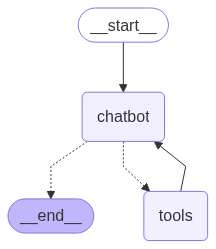

In [14]:
memory = MemorySaver()
state_graph = graph_builder.compile(checkpointer=memory)
display(Image(state_graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await state_graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
